In [32]:
import Bio.PDB
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt 

In [33]:
pdb_file = Path(Path.home(), "Documents/mtorc2/data/pdb/mTORC2.rigid_body.pdb")
intra_xl_file = Path(Path.home(), "Documents/mtorc2/data/xlms/xl_intra_formatted.csv")
inter_xl_file = Path(Path.home(), "Documents/mtorc2/data/xlms/xl_inter_formatted.csv")

In [34]:
aas = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLU", "GLN", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]
pdb_parser = Bio.PDB.PDBParser(QUIET=True)
model = pdb_parser.get_structure("reference", str(pdb_file))[0]


In [35]:
chain_ids = dict() 
chain_ids["MTOR"] = "A"
chain_ids["RICTOR"] = "B"
# chain_ids["MSIN1"] = "G"
chain_ids["MLST8"] = "C"

In [36]:
chains = dict() 
for chain in model:
    chains[chain.id] = chain

In [37]:
xls_df = pd.read_csv(inter_xl_file)
xls_df = pd.concat([xls_df, pd.read_csv(intra_xl_file)], axis=0)
xls_df.head()

,Unnamed: 0,prot1,res1,prot2,res2
0,0,MTOR,1197,RICTOR,516
1,1,MTOR,1218,RICTOR,516
2,2,RICTOR,1642,MSIN1,102
3,3,RICTOR,1092,MTOR,1993
4,4,RICTOR,1642,MSIN1,104


In [38]:
len(xls_df)

219

In [39]:
xls_df['contains'] = False
xls_df['satisfied'] = False
xls_df.head()

,Unnamed: 0,prot1,res1,prot2,res2,contains,satisfied
0,0,MTOR,1197,RICTOR,516,False,False
1,1,MTOR,1218,RICTOR,516,False,False
2,2,RICTOR,1642,MSIN1,102,False,False
3,3,RICTOR,1092,MTOR,1993,False,False
4,4,RICTOR,1642,MSIN1,104,False,False


In [40]:
# Remove any duplicate entries.
duplicates = list() 
for i in range(len(xls_df)): 
    prot1 = xls_df.iloc[i, xls_df.columns.get_loc("prot1")]
    prot2 = xls_df.iloc[i, xls_df.columns.get_loc("prot2")]
    res1 = xls_df.iloc[i, xls_df.columns.get_loc("res1")]
    res2 = xls_df.iloc[i, xls_df.columns.get_loc("res2")]
    
    for j in range(i+1, len(xls_df)): 
        cur_prot1 = xls_df.iloc[j, xls_df.columns.get_loc("prot1")]
        cur_prot2 = xls_df.iloc[j, xls_df.columns.get_loc("prot2")]
        cur_res1 = xls_df.iloc[j, xls_df.columns.get_loc("res1")]
        cur_res2 = xls_df.iloc[j, xls_df.columns.get_loc("res2")]
        
        if prot1 == cur_prot1 and prot2 == cur_prot2 and res1 == cur_res1 and res2 == cur_res2: 
            duplicates.append((i,j))
        elif prot1 == cur_prot2 and prot2 == cur_prot1 and res1 == cur_res2 and res2 == cur_res1:
            duplicates.append((i,j))

            

In [41]:
xls_df = xls_df.reset_index()
xls_df = xls_df.drop(columns=["Unnamed: 0"])
xls_df = xls_df.drop(columns=["index"])

In [42]:
xls_df.tail()

,prot1,res1,prot2,res2,contains,satisfied
214,AKT1,140,AKT1,214,False,False
215,MTOR,980,MTOR,1256,False,False
216,RICTOR,781,RICTOR,813,False,False
217,MTOR,309,MTOR,2370,False,False
218,RICTOR,1092,RICTOR,1107,False,False


In [43]:
xls_df = xls_df.drop([second for first, second in duplicates])
xls_df.tail()

,prot1,res1,prot2,res2,contains,satisfied
213,MTOR,298,MTOR,309,False,False
214,AKT1,140,AKT1,214,False,False
215,MTOR,980,MTOR,1256,False,False
217,MTOR,309,MTOR,2370,False,False
218,RICTOR,1092,RICTOR,1107,False,False


In [44]:
print(len(xls_df))

200


In [46]:
cutoff = 35
for i in range(len(xls_df)): 
    prot1 = xls_df.iloc[i]["prot1"]
    prot2 = xls_df.iloc[i]["prot2"]
    res1 = int(xls_df.iloc[i]["res1"])
    res2 = int(xls_df.iloc[i]["res2"])

    if prot1 == "AKT1" or prot2 == "AKT1": 
        continue
    if prot1 == "MSIN1" or prot2 == "MSIN1": 
        continue
        
    # Check if contains
    chain1 = chains[chain_ids[prot1]]
    chain2 = chains[chain_ids[prot2]]
    if chain1.__contains__(res1) and chain2.__contains__(res2): 
        # Check if satisfied 
        xls_df.iloc[i, xls_df.columns.get_loc('contains')] = True
        pos1 = chain1.__getitem__(res1)['CA'].coord
        pos2 = chain2.__getitem__(res2)['CA'].coord
        l2norm = np.linalg.norm(pos1 - pos2)
        if l2norm < cutoff: 
            print(prot1, prot2, res1, res2, l2norm)
            xls_df.iloc[i, xls_df.columns.get_loc('satisfied')] = True


MLST8 MTOR 86 2374 17.096048
MTOR RICTOR 2113 274 13.305797
MTOR RICTOR 2113 270 9.060984
MTOR MTOR 900 2218 9.976592
RICTOR RICTOR 791 813 11.376223
RICTOR RICTOR 764 800 12.168988
RICTOR RICTOR 791 826 18.622425
MTOR MTOR 1655 1745 17.491295
RICTOR RICTOR 374 734 9.027184
RICTOR RICTOR 541 582 15.149126
RICTOR RICTOR 800 856 14.9551525
RICTOR RICTOR 800 734 17.629921
RICTOR RICTOR 921 856 20.653751
MTOR MTOR 1267 1293 12.758361
RICTOR RICTOR 692 719 13.855674
RICTOR RICTOR 239 916 10.650063
RICTOR RICTOR 374 800 20.31656
RICTOR RICTOR 764 856 15.67747
MTOR MTOR 1277 226 10.873632
MTOR MTOR 2352 900 19.275755
MTOR MTOR 2301 1406 15.141727
MTOR MTOR 2045 2090 14.408097
MTOR MTOR 2166 2370 20.065783
MTOR MTOR 1566 226 27.505562
MTOR MTOR 128 84 12.338616
MTOR MTOR 898 1662 18.800428
RICTOR RICTOR 764 791 20.667387
MTOR MTOR 1277 230 17.340063
MTOR MTOR 1702 1655 12.750724
MTOR MTOR 1500 1471 12.184431
MTOR MTOR 898 1655 17.877752
RICTOR RICTOR 699 734 10.672991
RICTOR RICTOR 781 813 11.

In [47]:
xls_df[(xls_df["prot1"]=="MTOR") & (xls_df["prot2"]=="RICTOR") & (xls_df["contains"])]

,prot1,res1,prot2,res2,contains,satisfied
26,MTOR,2113,RICTOR,274,True,True
48,MTOR,1766,RICTOR,586,True,False
49,MTOR,2113,RICTOR,270,True,True


In [48]:
xls_df[(xls_df["prot2"]=="MTOR") & (xls_df["prot1"]=="RICTOR") & (xls_df["contains"])]

,prot1,res1,prot2,res2,contains,satisfied
28,RICTOR,699,MTOR,84,True,False
55,RICTOR,126,MTOR,2370,True,False


In [49]:
save_file = Path(Path.home(), "Documents/mtorc2/utility/initial_model/data/init_xl_satisfaction.csv")
xls_df.to_csv(save_file)
xls_df.head()

,prot1,res1,prot2,res2,contains,satisfied
0,MTOR,1197,RICTOR,516,False,False
1,MTOR,1218,RICTOR,516,False,False
2,RICTOR,1642,MSIN1,102,False,False
3,RICTOR,1092,MTOR,1993,False,False
4,RICTOR,1642,MSIN1,104,False,False


In [50]:
n_contains = dict()
n_satisfied = dict() 
n_xls = dict() 

prots = ["MTOR", "RICTOR", "MSIN1", "MLST8", "AKT1"]
for prot in prots: 
    for prot2 in prots: 
        entry = prot + "|" + prot2
        if prot2 + "|" + prot not in n_contains.keys(): 
            n_contains[entry] = 0
            n_satisfied[entry] = 0
            n_xls[entry] = 0

In [51]:
for i in range(len(xls_df)): 
    prot1 = xls_df.iloc[i, xls_df.columns.get_loc('prot1')]
    prot2 = xls_df.iloc[i, xls_df.columns.get_loc('prot2')]
    
    entry = prot1 + "|" + prot2
    if entry not in n_contains.keys(): 
        entry = prot2 + "|" + prot1

    n_xls[entry] = n_xls[entry] + 1

    if xls_df.iloc[i, xls_df.columns.get_loc('contains')]: 
        n_contains[entry] = n_contains[entry] + 1
        
    if xls_df.iloc[i, xls_df.columns.get_loc('satisfied')]:
        n_satisfied[entry] = n_satisfied[entry] + 1 

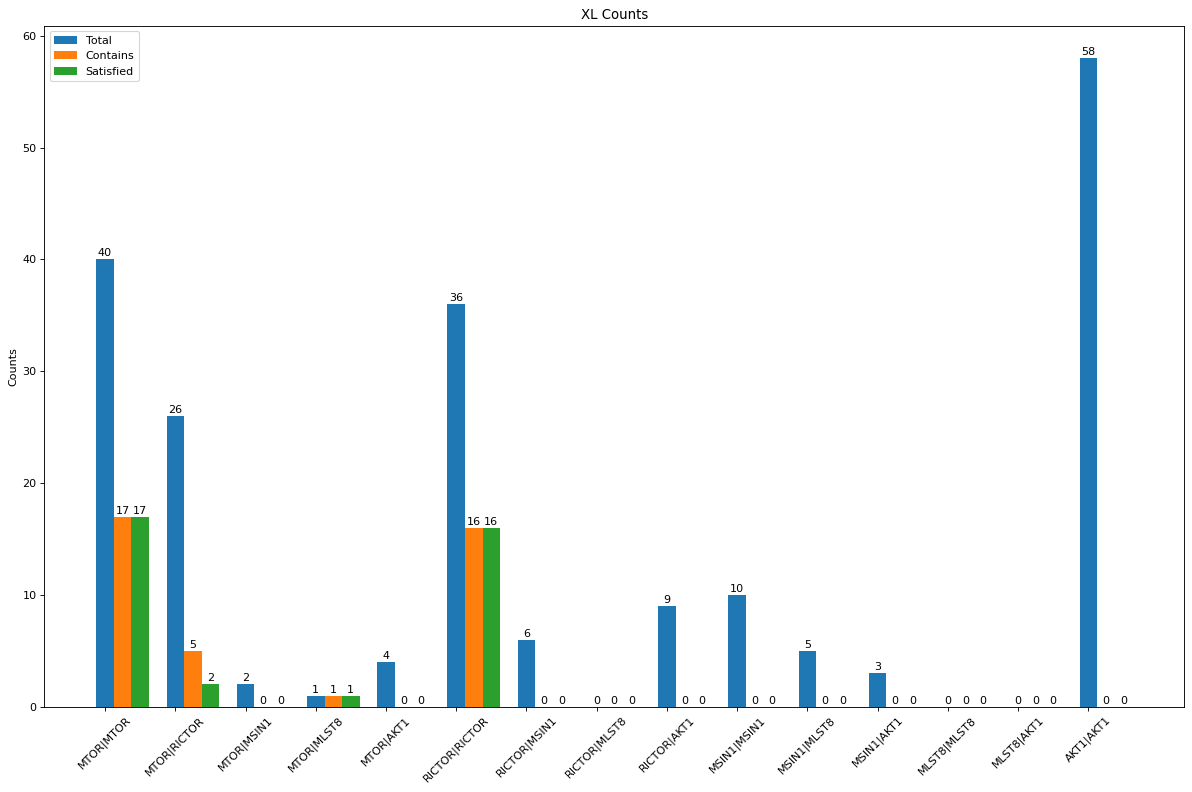

In [52]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=80) 
labels = list(n_contains.keys())
contains_list = [n_contains[key] for key in n_contains.keys()]
satisfied_list = [n_satisfied[key] for key in n_contains.keys()]
n_xls_list = [n_xls[key] for key in n_contains.keys()]

x = np.arange(len(labels))  # the label locations
width = .75  # the width of the bars

rects3 = ax.bar(x, n_xls_list, width/3, label='Total')
rects1 = ax.bar(x + width/3, contains_list, width/3, label='Contains')
rects2 = ax.bar(x + 2*width/3, satisfied_list, width/3, label='Satisfied')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('XL Counts')
ax.set_xticks(x, labels)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)
ax.bar_label(rects3, padding=1)

fig.tight_layout()
plt.show()

#### Create psuedobond (.pb) files

In [57]:
for i in range(len(xls_df)): 
    if xls_df.iloc[i, xls_df.columns.get_loc("contains")]: 
        if xls_df.iloc[i, xls_df.columns.get_loc("satisfied")]: 
            color="green"
        else: 
            color="red"
        
        
        res1 = xls_df.iloc[i, xls_df.columns.get_loc("res1")]
        res2 = xls_df.iloc[i, xls_df.columns.get_loc("res2")]
        
        chain1 = chain_ids[xls_df.iloc[i, xls_df.columns.get_loc("prot1")]]
        chain2 = chain_ids[xls_df.iloc[i, xls_df.columns.get_loc("prot2")]]

        print("#0:{}.{}@CA #0:{}.{}@CA {}".format(res1, chain1, res2, chain2, color))

#0:86.C@CA #0:2374.A@CA green
#0:2113.A@CA #0:274.B@CA green
#0:699.B@CA #0:84.A@CA red
#0:1766.A@CA #0:586.B@CA red
#0:2113.A@CA #0:270.B@CA green
#0:126.B@CA #0:2370.A@CA red
#0:900.A@CA #0:2218.A@CA green
#0:791.B@CA #0:813.B@CA green
#0:764.B@CA #0:800.B@CA green
#0:791.B@CA #0:826.B@CA green
#0:1655.A@CA #0:1745.A@CA green
#0:374.B@CA #0:734.B@CA green
#0:541.B@CA #0:582.B@CA green
#0:800.B@CA #0:856.B@CA green
#0:800.B@CA #0:734.B@CA green
#0:921.B@CA #0:856.B@CA green
#0:1267.A@CA #0:1293.A@CA green
#0:692.B@CA #0:719.B@CA green
#0:239.B@CA #0:916.B@CA green
#0:374.B@CA #0:800.B@CA green
#0:764.B@CA #0:856.B@CA green
#0:1277.A@CA #0:226.A@CA green
#0:2352.A@CA #0:900.A@CA green
#0:2301.A@CA #0:1406.A@CA green
#0:2045.A@CA #0:2090.A@CA green
#0:2166.A@CA #0:2370.A@CA green
#0:1566.A@CA #0:226.A@CA green
#0:128.A@CA #0:84.A@CA green
#0:898.A@CA #0:1662.A@CA green
#0:764.B@CA #0:791.B@CA green
#0:1277.A@CA #0:230.A@CA green
#0:1702.A@CA #0:1655.A@CA green
#0:1500.A@CA #0:1471.A@CA 